# Jurasic Park Simulation

## Configuraciones globales

In [10]:
%pip install matplotlib numpy experta noise pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from app.models.dinosaurios import *
from app.models.entorno import Entorno
from app.utils.draw_map import dibujar_mapa
from app.utils.batch_simulate import batch_simulate
from app.utils.genetic_algorithm import GeneticAlgorithm
from app.utils.procedural_algorithm import procedural_algorithm_for_generate_map

## Generación de mapa utilizando algoritmo procedural

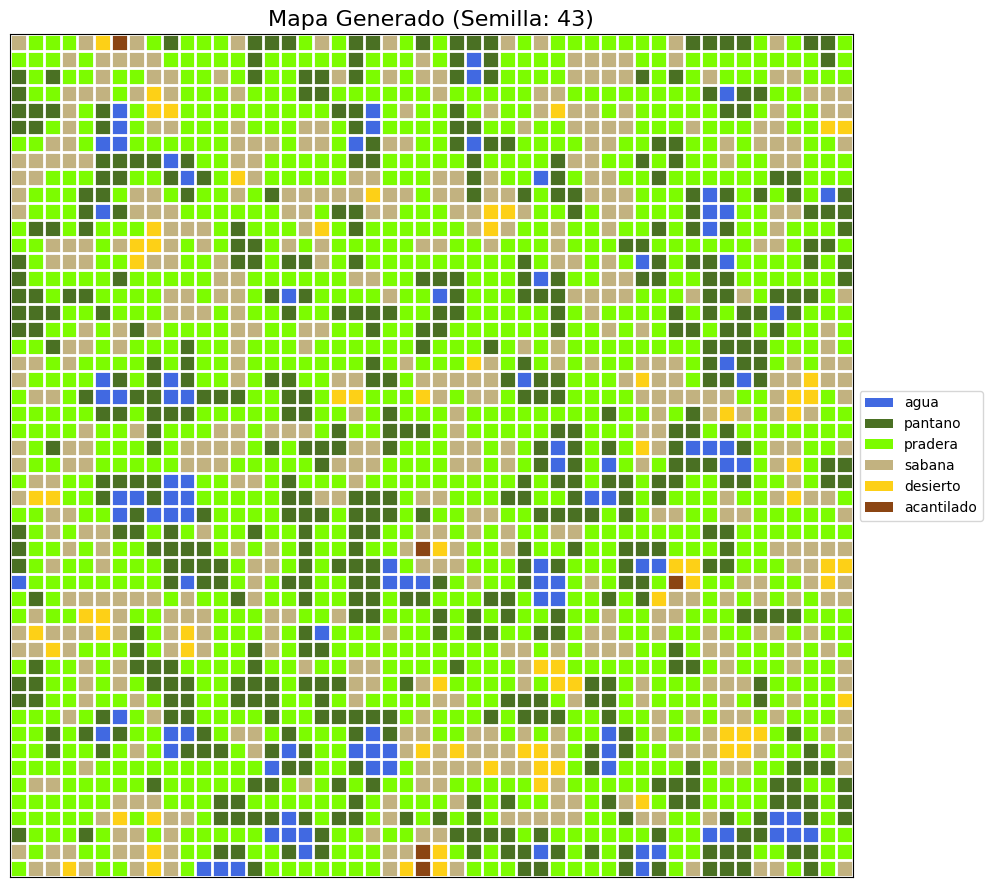

In [4]:
seeds = [43]
procedural_algorithm_for_generate_map(seeds)

### Seleccionar mapa

In [6]:
with open('app/data/map_seed_43.json', 'r') as file:
    mapa_data = json.load(file)

## Generar conjunto de personalidades utilizando mistral


#### [NOTA]
> Solo ejecute ésta sección si desea utilizar un nuevo mapa en vez del mapa por defecto.

### **Instalación**

In [54]:
%pip install python-dotenv mistralai

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [134]:
from dotenv import load_dotenv
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
import os

from app.models.entorno import TERRENO_TIPOS

# Carga las variables de entorno desde el archivo .env
load_dotenv()

# Obtiene la API key de Mistral desde las variables de entorno
API_KEY = "7K5XJOFkbEEKjOkamr2GVneMiAQK5j75" # os.getenv("MISTRAL_API_KEY")

def get_mistral_response():
    # Prepara el mensaje a enviar basado en el input del usuario
    
    msg = """Genera un diccionario en Python que represente 5 personalidades diferentes para personajes de un juego de rol. 
    Cada personalidad debe tener tres habilidades: fuerza, velocidad, resistencia, inteligencia, adaptabilidad y supervivencia, 
    con valores entre 0 y 100. Además, proporciona un nombre descriptivo para cada personalidad. El diccionario debe tener la 
    siguiente estructura:

    {
    'habilidades': [
    {'fuerza': X, 'inteligencia': Y, 'resistencia': Z},
    {...},
    {...},
    {...},
    {...}
    ],
    'nombres': [
    'Nombre descriptivo 1',
    'Nombre descriptivo 2',
    'Nombre descriptivo 3',
    'Nombre descriptivo 4',
    'Nombre descriptivo 5'
    ]
    }

    Asegúrate de que los valores de las habilidades sean variados y que los nombres sean descriptivos de las 
    características principales de cada personalidad. Proporciona solo el diccionario en tu respuesta, sin 
    explicaciones adicionales, para que pueda ser parseado directamente con json.loads() en Python."""
    
    # Inicializa la lista de mensajes con el mensaje construido
    messages = [ChatMessage(role="user", content=msg)]
    
    # Crea una instancia del cliente de Mistral
    llm_client = MistralClient(api_key=API_KEY)
    
    # Inicializa la cadena de respuesta
    response = ""
    
    # Realiza la petición a Mistral y acumula las respuestas
    for chunk in llm_client.chat_stream(messages, model="mistral-small"):
        response += chunk.choices[0].delta.content

    return response


personalidades = get_mistral_response()

In [155]:
print(personalidades)

{
    "habilidades": [
        {
            "fuerza": 80,
            "velocidad": 60,
            "resistencia": 90,
            "inteligencia": 30,
            "adaptabilidad": 50,
            "supervivencia": 70
        },
        {
            "fuerza": 50,
            "velocidad": 90,
            "resistencia": 60,
            "inteligencia": 70,
            "adaptabilidad": 80,
            "supervivencia": 40
        },
        {
            "fuerza": 70,
            "velocidad": 70,
            "resistencia": 80,
            "inteligencia": 60,
            "adaptabilidad": 60,
            "supervivencia": 60
        },
        {
            "fuerza": 40,
            "velocidad": 100,
            "resistencia": 30,
            "inteligencia": 90,
            "adaptabilidad": 90,
            "supervivencia": 50
        },
        {
            "fuerza": 60,
            "velocidad": 50,
            "resistencia": 70,
            "inteligencia": 80,
            "adaptabilidad": 70,

In [151]:
import json

personalidades_dict = json.loads(personalidades)
personalidades_dict['nombres'].reverse()

print(personalidades_dict)

{'habilidades': [{'fuerza': 80, 'velocidad': 60, 'resistencia': 90, 'inteligencia': 30, 'adaptabilidad': 50, 'supervivencia': 70}, {'fuerza': 50, 'velocidad': 90, 'resistencia': 60, 'inteligencia': 70, 'adaptabilidad': 80, 'supervivencia': 40}, {'fuerza': 70, 'velocidad': 70, 'resistencia': 80, 'inteligencia': 60, 'adaptabilidad': 60, 'supervivencia': 60}, {'fuerza': 40, 'velocidad': 100, 'resistencia': 30, 'inteligencia': 90, 'adaptabilidad': 90, 'supervivencia': 50}, {'fuerza': 60, 'velocidad': 50, 'resistencia': 70, 'inteligencia': 80, 'adaptabilidad': 70, 'supervivencia': 80}], 'nombres': ['El Adaptable', 'El Inteligente', 'El Resistente', 'El Rápido', 'El Bruto']}


## Simulaciones iniciales con valores aleatorios

In [7]:
def simulaciones_aleatorias(n_simulaciones, dinosaurios=[], reproduccion=True):

    entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

    resultados_sin_dinosaurios = batch_simulate(
        n_simulations=n_simulaciones,
        reproduccion=reproduccion,
        entorno=entorno
    )
    
    resultados_con_dinosaurios = batch_simulate(
        n_simulations=n_simulaciones,
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    for i, r in enumerate(resultados_sin_dinosaurios):
        ax1.plot(r['poblacion'], label=f'Simulacion {i + 1}', color='b')
        ax1.set_title('Prueba de supervivencia sin dinosaurios')
        ax1.set_xlabel('Ciclos')
        ax1.set_ylabel('Población')
        ax1.grid(True)
    
    for i, r in enumerate(resultados_con_dinosaurios):
        ax2.plot(r['poblacion'], label=f'Simulacion {i + 1}', color='r')
        ax2.set_title('Prueba de supervivencia con dinosaurios')
        ax2.set_xlabel('Ciclos')
        ax2.set_ylabel('Población')
        ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

### Simulación sin dinosaurios

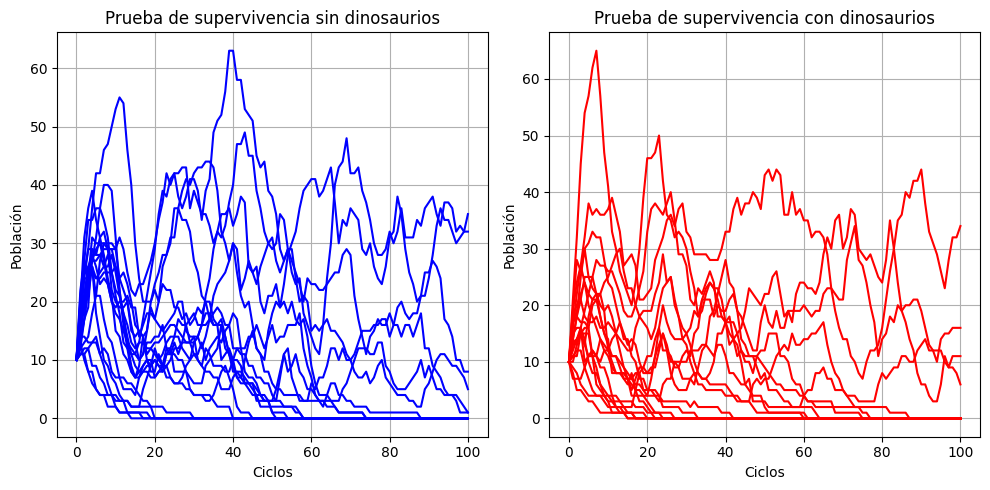

In [8]:
simulaciones_aleatorias(
    n_simulaciones=20,
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ]
)

## Hipótesis 1: La genética y las habilidades afectan significativamente la supervivencia

In [140]:
def batch_simulate_genotipos(n_simulaciones, dinosaurios=[], reproduccion=True):
    resultados_batch = []
    
    genotipos_config = personalidades_dict["habilidades"]

    entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

    for genotipo in genotipos_config:
        poblacion_final = []

        results = batch_simulate(
            n_simulations=n_simulaciones,
            genotipo=genotipo,
            dinosaurios=dinosaurios,
            reproduccion=reproduccion,
            entorno=entorno
        )

        for i, result in enumerate(results):
            poblacion_final.append(result['poblacion'][-1])  # Población al final de la simulación

        # Guardar los resultados de cada configuración de genotipo
        resultados_batch.append({
            'genotipo': genotipo,
            'poblacion': result['poblacion'],
            'results': results,
            'poblacion_final': np.mean(poblacion_final)
        })

    return resultados_batch


In [152]:
def visualizar_resultados_batch(resultados_batch):
    # Extraer la información para graficar
    # genotipos = ["Humanos fuertes", "Humanos inteligentes", "Humanos balanceados", "Humanos resistentes"]
    genotipos = personalidades_dict["nombres"]
    poblacion_final = [r['poblacion_final'] for r in resultados_batch]

    # Crear gráfico de barras para visualizar la hipótesis
    plt.figure(figsize=(10, 6))
    plt.bar(genotipos, poblacion_final)
    plt.title('Efecto de Genotipos en la Supervivencia')
    plt.xlabel('Genotipo (Fuerza, Inteligencia, Resistencia)')
    plt.ylabel('Población Final Promedio')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


### Hagamos una primera simulacion sin dinosaurios y veamos los resultados.

In [147]:
# Ejecutar simulacion sin dinosaurios
resultados_batch = batch_simulate_genotipos(
    n_simulaciones=50,
)

/home/dukagin/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dukagin/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


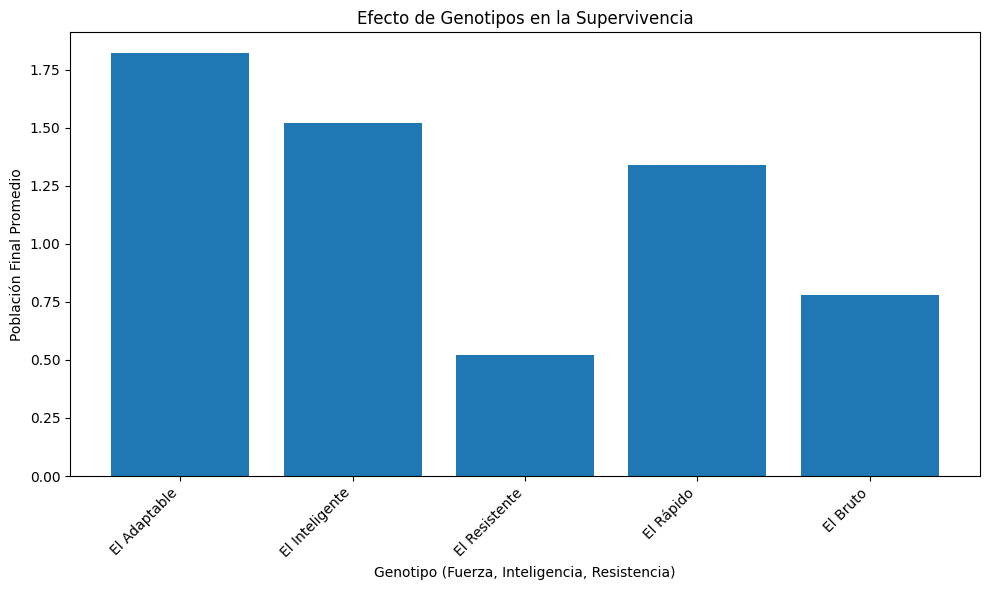

In [153]:
# Visualizar los resultados
visualizar_resultados_batch(resultados_batch)

### Ahora hagamos una simulación agregando los dinosaurios al ecosistema

In [149]:
# Ejecutar simulaciones con dinosaurios
resultados_batch_dinosaurios = batch_simulate_genotipos(
    n_simulaciones=50,
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ]
)

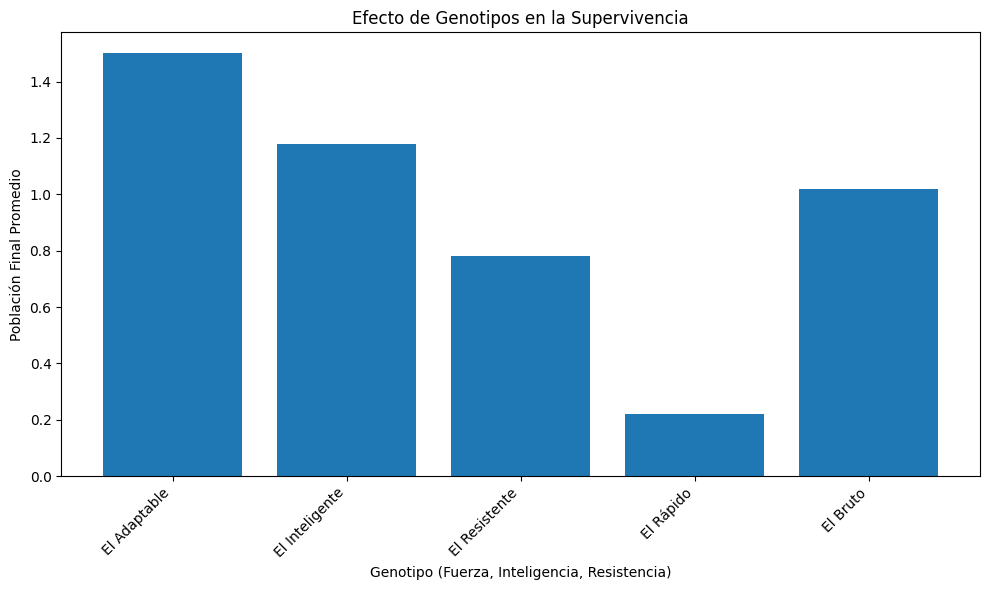

In [154]:
visualizar_resultados_batch(resultados_batch_dinosaurios)

## Hipótesis: La adaptabilidad mejora la capacidad de supervivencia en entornos cambiantes

In [47]:
def evaluar_hipotesis_adaptabilidad(n_simulaciones, dinosaurios=[], reproduccion=True):

    entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

    # Simulamos tres escenarios con diferentes niveles de adaptabilidad
    resultados_baja = batch_simulate(
        n_simulations=n_simulaciones,
        genotipo={'adaptabilidad': 20},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )
    resultados_media = batch_simulate(
        n_simulations=n_simulaciones,
        genotipo={'adaptabilidad': 50},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )
    resultados_alta = batch_simulate(
        n_simulations=n_simulaciones,
        genotipo={'adaptabilidad': 80},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    for r in resultados_baja:
        plt.plot(r['poblacion'], label='Adaptabilidad Baja', color='r')

    for r in resultados_media:
        plt.plot(r['poblacion'], label='Adaptabilidad Media', color='g')

    for r in resultados_alta:
        plt.plot(r['poblacion'], label='Adaptabilidad Alta', color='b')

    plt.title('Supervivencia vs Ciclos con Diferentes Niveles de Adaptabilidad')
    plt.xlabel('Ciclos')
    plt.ylabel('Población')
    plt.legend()
    plt.grid(True)
    plt.show()


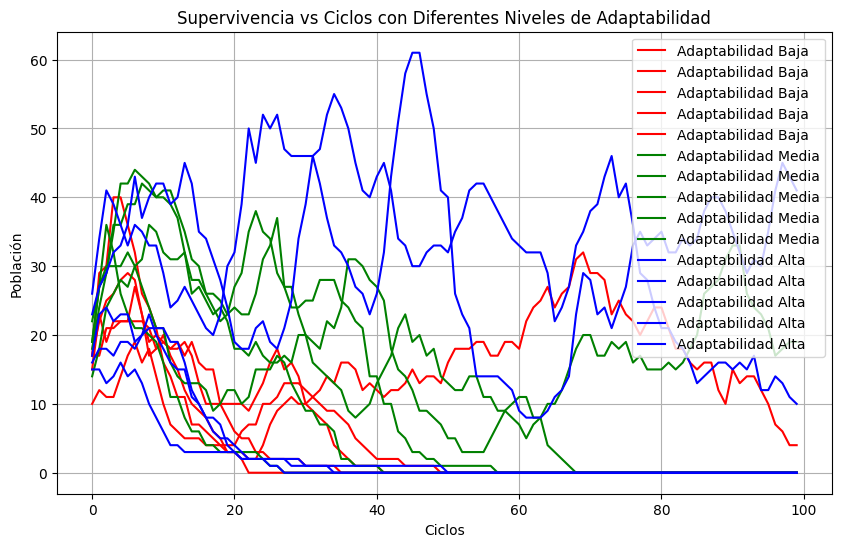

In [48]:
evaluar_hipotesis_adaptabilidad(
    n_simulaciones=5,
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ]
)

## Algoritmo Genético

In [20]:
entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

genetic_algorithm = GeneticAlgorithm(
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ],
    entorno=entorno
)

In [21]:
genetic_algorithm.evolucionar()
genetic_algorithm.seleccion()

In [22]:
print(genetic_algorithm.poblacion[0].genotipo)

{'fuerza': 65, 'velocidad': 12, 'resistencia': 24, 'inteligencia': 66, 'adaptabilidad': 16, 'supervivencia': 36}


In [50]:
genetic_algorithm.evolucionar()
genetic_algorithm.seleccion()
print(genetic_algorithm.poblacion[0].genotipo)

{'fuerza': 63, 'velocidad': 76, 'resistencia': 15, 'inteligencia': 4, 'adaptabilidad': 56, 'supervivencia': 90}


### Comprobando resultados anteriores

In [49]:
def evaluar_hipotesis_adaptabilidad(n_simulaciones, dinosaurios=[], reproduccion=True):

    entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

    # Simulamos tres escenarios con diferentes niveles de adaptabilidad
    resultados = batch_simulate(
        n_simulations=n_simulaciones,
        # genotipo={'fuerza': 24, 'velocidad': 36, 'resistencia': 71, 'inteligencia': 67, 'adaptabilidad': 77, 'supervivencia': 62},
        genotipo={'fuerza': 65, 'velocidad': 12, 'resistencia': 24, 'inteligencia': 66, 'adaptabilidad': 16, 'supervivencia': 36},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )
    
    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    for i, r in enumerate(resultados):
        plt.plot(r['poblacion'], label=f'Simulacion {i + 1}', color='b')

    plt.title('Prueba de los índices genéticos encontrados por el AG')
    # plt.subtitle("'fuerza': 24, 'velocidad': 36, 'resistencia': 71, 'inteligencia': 67, 'adaptabilidad': 77, 'supervivencia': 62")
    plt.xlabel('Ciclos')
    plt.ylabel('Población')
    # plt.legend()
    plt.grid(True)
    plt.show()

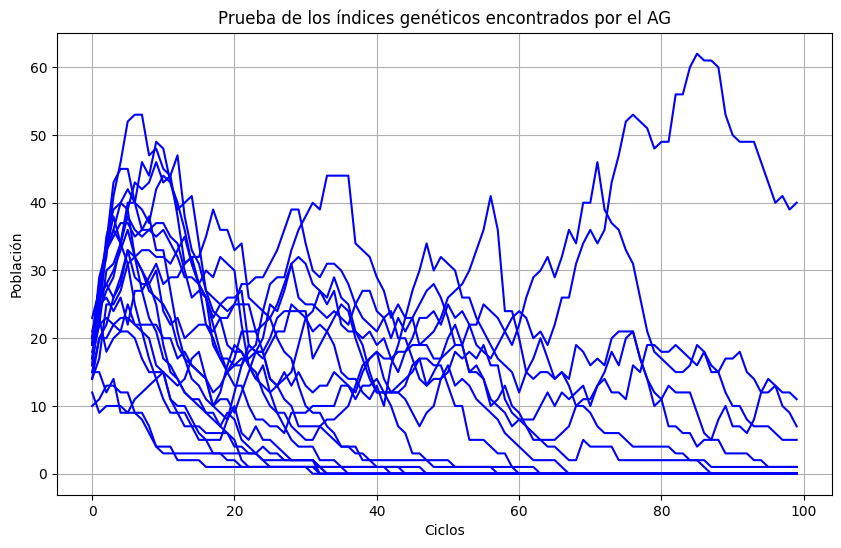

In [28]:
evaluar_hipotesis_adaptabilidad(
    n_simulaciones=20,
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ]
)

### Otro algoritmo Genético

In [51]:
def evaluar_hipotesis_adaptabilidad(n_simulaciones, dinosaurios=[], reproduccion=True):

    entorno = Entorno(mapa_data['tamanio'], np.matrix(mapa_data['terreno']))

    # Simulamos tres escenarios con diferentes niveles de adaptabilidad
    resultados = batch_simulate(
        n_simulations=n_simulaciones,
        # genotipo={'fuerza': 65, 'velocidad': 12, 'resistencia': 24, 'inteligencia': 66, 'adaptabilidad': 16, 'supervivencia': 36},
        genotipo={'fuerza': 63, 'velocidad': 76, 'resistencia': 15, 'inteligencia': 4, 'adaptabilidad': 56, 'supervivencia': 90},
        dinosaurios=dinosaurios,
        reproduccion=reproduccion,
        entorno=entorno
    )
    
    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    for i, r in enumerate(resultados):
        plt.plot(r['poblacion'], label=f'Simulacion {i + 1}', color='b')

    plt.title('Prueba de los índices genéticos encontrados por el AG')
    # plt.subtitle("'fuerza': 24, 'velocidad': 36, 'resistencia': 71, 'inteligencia': 67, 'adaptabilidad': 77, 'supervivencia': 62")
    plt.xlabel('Ciclos')
    plt.ylabel('Población')
    # plt.legend()
    plt.grid(True)
    plt.show()

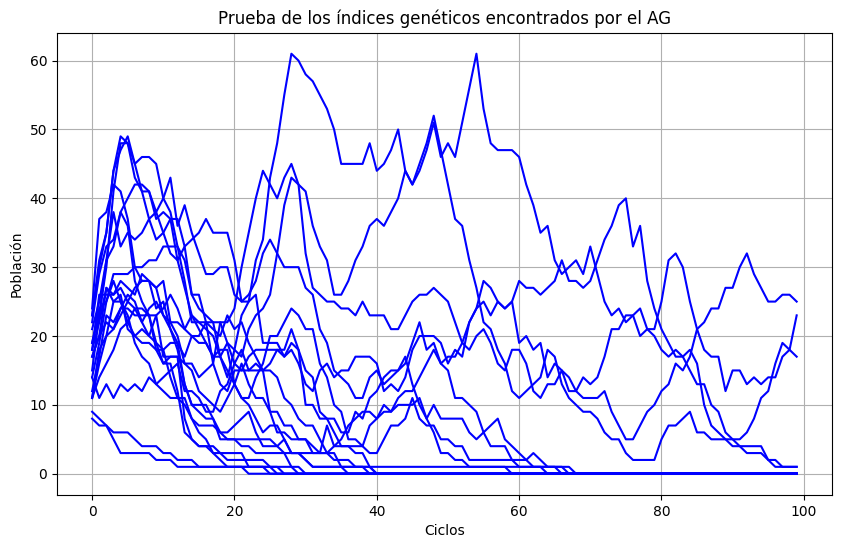

In [52]:
evaluar_hipotesis_adaptabilidad(
    n_simulaciones=20,
    dinosaurios=[
        Braquiosaurio, Triceratops, Pteranodonte, Velociraptor, TiranosaurioRex
    ]
)